In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# Data Downloading and Processing
1. Download stock data
2. Download ETF data
3. Process ETF data for PCA

In [3]:
# 1. Download data

start_date = '2020-01-01'
end_date = '2023-12-31'

# Download universe data
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'JPM', 'BAC', 'WMT',
    'PG', 'JNJ', 'UNH', 'HD', 'MA', 'V', 'DIS', 'NFLX', 'CSCO', 'INTC',
    'PFE', 'KO', 'PEP', 'MRK', 'VZ', 'T', 'CMCSA', 'ABT', 'MCD', 'ADBE',
    'CRM', 'NKE', 'TMO', 'COST', 'DHR', 'ACN', 'LLY', 'AVGO', 'TXN', 'UNP',
    'NEE', 'BMY', 'RTX', 'QCOM', 'ORCL', 'HON', 'UPS', 'IBM', 'LIN', 'AMT',
    'CVX', 'XOM', 'BA', 'CAT', 'GS', 'MS', 'BLK', 'C', 'WFC', 'AXP',
    'MMM', 'GE', 'F', 'GM', 'SBUX', 'MO', 'PM', 'CVS', 'LOW', 'TGT',
    'AMD', 'PYPL', 'BKNG', 'GILD', 'MDLZ', 'TMUS', 'TJX', 'SPGI', 'BDX', 'ADP',
    'ZTS', 'ISRG', 'CI', 'ANTM', 'CCI', 'DUK', 'SO', 'D', 'AEP', 'EXC',
    'PLD', 'COP', 'EOG', 'SLB', 'OXY', 'PSX', 'KMI', 'MPC', 'VLO', 'HAL'
]

tickers = ['MSFT']


df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data.columns = data.columns.droplevel(['Ticker'])
    data = data[['Close']]
    data = data.rename(columns={'Close': ticker})
    df = pd.concat([df, data], axis=1)

df = df.dropna(axis=1)

for col in df.columns:
    df[col] = df[col].pct_change()
df = df.dropna(axis = 0)


# Download ETF data
ETF_tickers = ['XLSR', 'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']
df_ETF = pd.DataFrame()

for ticker in ETF_tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data.columns = data.columns.droplevel(['Ticker'])
    data = data[['Close']]
    data = data.rename(columns={'Close': ticker})
    df_ETF = pd.concat([df_ETF, data], axis=1)

for col in df_ETF.columns:
    df_ETF[col] = df_ETF[col].pct_change()
df_ETF = df_ETF.dropna()


# Process PCA data
pca = PCA(n_components=len(df_ETF.columns))
pca.fit(df_ETF)
df_ETF_PCA = pca.transform(df_ETF)
df_ETF_PCA = pd.DataFrame(df_ETF_PCA, columns=[f'PCA_{i}' for i in range(df_ETF_PCA.shape[1])])
df_ETF_PCA.index = df_ETF.index

explained_variance = pca.explained_variance_ratio_
explained_variance_cumsum = np.cumsum(explained_variance)
for i in range(len(explained_variance_cumsum)):
    if explained_variance_cumsum[i] >= 0.9:
        df_ETF_PCA = df_ETF_PCA.drop(columns=[f'PCA_{i}'])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# OU process fitting function

In [4]:
def fit_ou_process_returns(returns, dt=1.0):
    """
    Fit Ornstein-Uhlenbeck parameters to return data using Maximum Likelihood Estimation
    
    Parameters:
    returns: numpy array or pandas series of returns (not prices)
    dt: time step between observations (1.0 for daily returns)
    
    Returns:
    theta: mean reversion rate
    mu: long-term mean return
    sigma: volatility of returns
    """
    # Convert to numpy array if pandas
    if isinstance(returns, pd.Series):
        returns = returns.values
    
    # For returns, we don't need to take differences
    x = returns[:-1]
    y = returns[1:]
    n = len(x)
    
    # Define negative log likelihood function
    def neg_log_likelihood(params):
        theta, mu, sigma = params
        
        # Expected next return according to OU
        expected_y = x * np.exp(-theta * dt) + mu * (1 - np.exp(-theta * dt))
        
        # Variance
        var = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * dt))
        
        # Log likelihood
        log_likelihood = -0.5 * n * np.log(2 * np.pi * var) - \
                        0.5 * np.sum((y - expected_y)**2) / var
        
        return -log_likelihood
    
    # Initial guess for parameters
    initial_guess = [2.0, np.mean(returns), np.std(returns)]
    
    # Bounds for parameters (all positive for theta and sigma)
    bounds = ((0.0001, None), (None, None), (0.0001, None))
    
    # Optimize
    result = minimize(neg_log_likelihood, initial_guess, bounds=bounds)
    
    theta, mu, sigma = result.x
    
    return float(theta), float(mu), float(sigma)



# Universe Selection
Only Select Stocks whose OU process has reversion time less than 21/252 (1 month), based on 2020-2021 data

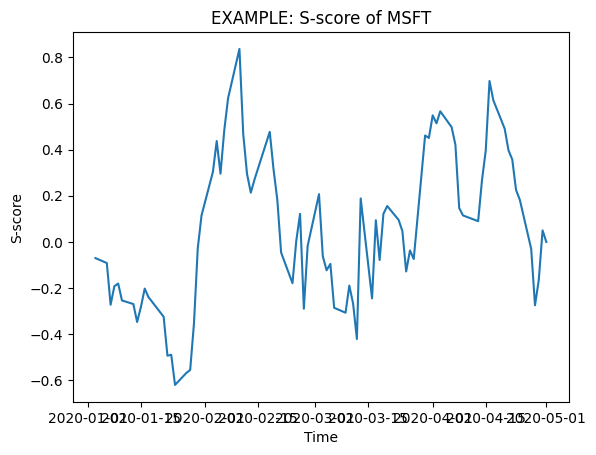

selected_tickers: ['MSFT']
reversion_times: {'MSFT': 0.06911637118010684}


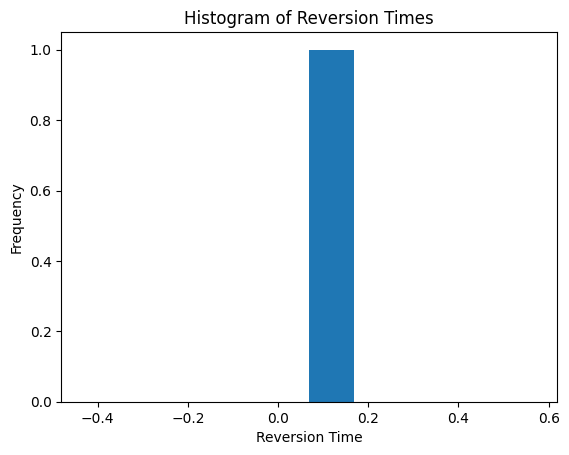

In [5]:
df_ETF_1 = df_ETF[df_ETF.index <= '2020-05-01']
df_1 = df[df.index <= '2020-05-01']

# statistic
selected_tickers = []
reversion_times = {}
S_score_thresholds = {}


for ticker in df.columns:
    stats_dict = {}

    # Create data
    df_ticker = pd.DataFrame()
    df_ticker['Y'] = df_1[ticker]
    df_ticker[list(df_ETF_1.columns)] = df_ETF_1
    df_ticker['dt'] = 1/252

    # Standardize the data
    X_cols = list(df_ETF_1.columns) + ['dt']
    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(df_ticker[X_cols])
    df_ticker[X_cols] = X_scaled
    
    # Fit the model
    lasso_model = linear_model.Lasso(alpha = 0.005)
    lasso_model.fit(df_ticker[X_cols], df_ticker['Y'])

    intercept = lasso_model.intercept_
    coefficients = lasso_model.coef_

    selected_ETFs = [X_cols[i] for i in range(len(X_cols)) if coefficients[i] != 0]

    # Calculate dX value for OU process
    df_ticker['dX'] = df_ticker['Y'] - lasso_model.predict(df_ticker[X_cols])
    df_ticker['X'] = df_ticker['dX'].cumsum()

    # Fit the OU process
    theta, mu, sigma = fit_ou_process_returns(df_ticker['dX'])

    # Calculate S value for OU process
    df_ticker['S'] = (df_ticker['X'] - mu) / sigma
    ##df_ticker['modified_S'] = ((df_ticker['S'] - mu) / sigma) - coefficients[-1] / theta / sigma

    reversion_time = 1 / theta
    reversion_times[ticker] = reversion_time
    if reversion_time < 21/252:
        selected_tickers.append(ticker)

        S_score_positive = [s for s in list(df_ticker['S']) if s > 0]
        S_score_negative = [s for s in list(df_ticker['S']) if s < 0]
        S_pos_entry = np.quantile(S_score_positive, 0.8)
        S_pos_exit = np.quantile(S_score_positive, 0.5)
        S_neg_entry = np.quantile(S_score_negative, 0.2)
        S_neg_exit = np.quantile(S_score_negative, 0.5)
        S_score_thresholds[ticker] = {'S_pos_entry': S_pos_entry, 'S_pos_exit': S_pos_exit, 'S_neg_entry': S_neg_entry, 'S_neg_exit': S_neg_exit}

        # Plot sample S-score plots
        if ticker == 'AAPL' or ticker == 'MSFT' or ticker == 'GOOGL' or ticker == 'AMZN' or ticker == 'META' or ticker == 'NVDA' or ticker == 'TSLA' or ticker == 'JPM' or ticker == 'BAC' or ticker == 'WMT':
            plt.plot(df_ticker['S'])
            plt.title(f'EXAMPLE: S-score of {ticker}')
            plt.xlabel('Time')
            plt.ylabel('S-score')
            plt.show()

    
df = df[selected_tickers]
df = df[df.index >= '2021-10-01']

df_trade = df[df.index >= '2022-01-01']

df_ETF = df_ETF[df_ETF.index >= '2021-10-01']
df_ETF_PCA = df_ETF_PCA[df_ETF_PCA.index >= '2021-10-01']

df_ETF_trade = df_ETF[df_ETF.index >= '2022-01-01']
df_ETF_PCA_trade = df_ETF_PCA[df_ETF_PCA.index >= '2022-01-01']

print(f'selected_tickers: {selected_tickers}')
print(f'reversion_times: {reversion_times}')

plt.hist(reversion_times.values())
plt.title(f'Histogram of Reversion Times')
plt.xlabel(f'Reversion Time')
plt.ylabel(f'Frequency')
plt.show()

Assumptions:
1. The backtest period is from 2022-01-01 to 2023-12-31.
2. We have 1M capital to start with.
3. We devide the 1M capital equally to the selected stocks.
4. Each separate Pairs-Trading portfolio per stock can only use its own capital. No reallocation.
5. For the purpose of research, there is no taking profit or stop loss. 
6. The OU process fitting happens every week, and the S-score is calculated every day. It is based on the past 63 days of data (incorporating an earnings cycle)

Work Flow:
1. We model market beta return using the ETFs.
2. We model market beta return using the PCAs of the ETFs.
3. We add volume adjustment to the above two approaches.

Presentations:
1. The PnL of the whole portfolio.
2. The PnL of the separate Pairs-Trading portfolio for each stock.

# The ETF Approach

1. Get the Pairs-Trading signals

In [6]:
def get_signal(S_score, position, S_pos_entry, S_pos_exit, S_neg_entry, S_neg_exit):
    signal = None
    new_position = None

    if position == 0:
        if S_score > S_pos_entry:
            signal = -1
            new_position = -1
        elif S_score < S_neg_entry:
            signal = 1
            new_position = 1
        else:
            signal = 0
            new_position = 0
    elif position == 1:
        if S_score > S_neg_exit:
            signal = -1
            new_position = 0
        else:
            signal = 0
            new_position = 1
    elif position == -1:
        if S_score < S_pos_exit:
            signal = 1
            new_position = 0
        else:
            signal = 0
            new_position = -1


    return signal, new_position


In [37]:
def weight_process(weights):
    summation = np.sum([abs(x) for x in weights]) + 1
    weights = [x / summation for x in weights]
    result = np.array(weights) * (-1)
    result = np.insert(result, 0, 1/summation)
    return result


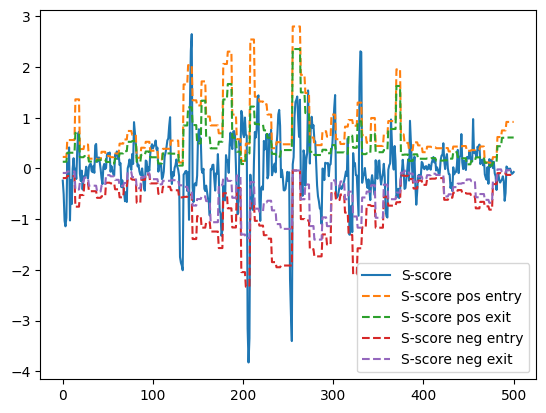

In [38]:
s_score_pos_entry_dict = {}
s_score_pos_exit_dict = {}
s_score_neg_entry_dict = {}
s_score_neg_exit_dict = {}

index_time = []
signals_dict = {}
s_score_dict = {}
positions_dict = {}
weights_dict = {}
for ticker in selected_tickers:
    signals_dict[ticker] = []
    s_score_dict[ticker] = []
    weights_dict[ticker] = []
    positions_dict[ticker] = [0] # 0 for no position, 1 for long when S-score is below neg_entry, -1 for short when S-score is above pos_entry

    s_score_pos_entry_dict[ticker] = []
    s_score_pos_exit_dict[ticker] = []
    s_score_neg_entry_dict[ticker] = []
    s_score_neg_exit_dict[ticker] = []

for t in df.index:
    if t < pd.to_datetime('2022-01-01'):
        continue


    if t.day_name() == 'Monday':
        week_data = {}

        # Get the start and end date for OU process fitting for the following week
        OU_start_date = t - pd.Timedelta(days=63)
        OU_end_date = t
        df_ETF_week = df_ETF[OU_start_date:OU_end_date]

        # Fit the model for each ticker
        for ticker in selected_tickers:            
            week_data_ticker = {}
            df_ticker_week = df[[ticker]][OU_start_date:OU_end_date]

            # Create data
            df_ticker_week = df_ticker_week.rename(columns={ticker: 'Y'})
            df_ticker_week[list(df_ETF_week.columns)] = df_ETF_week
            df_ticker_week['dt'] = 1/252
            X_cols = list(df_ETF_week.columns) + ['dt']

            df_ticker_week_original = df_ticker_week.copy()

            # Standardize the data
            X_scaler = StandardScaler()
            X_scaled = X_scaler.fit_transform(df_ticker_week[X_cols])
            df_ticker_week[X_cols] = X_scaled
            df_ticker_week = df_ticker_week.dropna(axis=0)

            # Fit the model
            lasso_model = linear_model.Lasso(alpha = 0.005)
            lasso_model.fit(df_ticker_week[X_cols], df_ticker_week['Y'])

            # Revert back the weights to the original scale
            original_scale_coef = lasso_model.coef_ / X_scaler.scale_  
            selected_ETFs = [X_cols[i] for i in range(len(X_cols)) if original_scale_coef[i] != 0][:-1]
            
            # original_intercept = (lasso_model.intercept_ - np.sum(lasso_model.coef_ * X_scaler.mean_ / X_scaler.scale_))
            # original_predictions = np.dot(df_ticker_week_original[X_cols], original_scale_coef) + original_intercept
            # original_residuals = df_ticker_week_original['Y'] - original_predictions
            # df_ticker_week['dX'] = original_residuals

            # Calculate dX value for OU process
            df_ticker_week['dX'] = df_ticker_week['Y'] - lasso_model.predict(df_ticker_week[X_cols])
            df_ticker_week['X'] = df_ticker_week['dX'].cumsum()
            df_ticker_week['S'] = (df_ticker_week['X'] - mu) / sigma

            S_score_positive = [s for s in list(df_ticker_week['S']) if s > 0]
            S_score_negative = [s for s in list(df_ticker_week['S']) if s < 0]
            if len(S_score_positive) > 0:
                S_pos_entry = np.quantile(S_score_positive, 0.8)
                S_pos_exit = np.quantile(S_score_positive, 0.5)
            else:
                S_pos_entry = S_score_thresholds[ticker]['S_pos_entry']
                S_pos_exit = S_score_thresholds[ticker]['S_pos_exit']
            if len(S_score_negative) > 0:
                S_neg_entry = np.quantile(S_score_negative, 0.2)
                S_neg_exit = np.quantile(S_score_negative, 0.5)
            else:
                S_neg_entry = S_score_thresholds[ticker]['S_neg_entry']
                S_neg_exit = S_score_thresholds[ticker]['S_neg_exit']

            # Fit the OU process
            theta, mu, sigma = fit_ou_process_returns(df_ticker_week['dX'])

            week_data_ticker['selected_ETFs'] = selected_ETFs
            week_data_ticker['mu'] = mu
            week_data_ticker['sigma'] = sigma
            week_data_ticker['theta'] = theta
            week_data_ticker['intercept'] = lasso_model.intercept_
            week_data_ticker['weights'] = weight_process(original_scale_coef[:-1])
            week_data_ticker['coefficients'] = lasso_model.coef_
            week_data_ticker['X_scaler'] = X_scaler
            week_data_ticker['lasso_model'] = lasso_model
            week_data_ticker['S_pos_entry'] = S_pos_entry
            week_data_ticker['S_pos_exit'] = S_pos_exit
            week_data_ticker['S_neg_entry'] = S_neg_entry
            week_data_ticker['S_neg_exit'] = S_neg_exit
            week_data_ticker['X'] = float(df_ticker_week['X'].iloc[-1])
            week_data[ticker] = week_data_ticker
            

    # Get the S-score for each ticker for each day of the following week
    for ticker in selected_tickers:
        df_ETF_today = df_ETF[df_ETF.index == t]
        df_ticker_today = df[df.index == t][[ticker]]
        df_ticker_today = df_ticker_today.rename(columns={ticker: 'Y'})
        df_ticker_today[list(df_ETF_today.columns)] = df_ETF_today
        df_ticker_today['dt'] = 1/252

        X_cols = list(df_ETF_today.columns) + ['dt']
        df_ticker_today[X_cols] = week_data[ticker]['X_scaler'].transform(df_ticker_today[X_cols])

        dX = (df_ticker_today['Y'] - week_data[ticker]['lasso_model'].predict(df_ticker_today[X_cols])).values[0]
        X_OU = week_data[ticker]['X'] + dX
        week_data[ticker]['X'] = X_OU
        S_score = (X_OU - week_data[ticker]['mu']) / week_data[ticker]['sigma']
        s_score_dict[ticker].append(S_score)
        signal, new_position = get_signal(S_score, positions_dict[ticker][-1], week_data[ticker]['S_pos_entry'], week_data[ticker]['S_pos_exit'], week_data[ticker]['S_neg_entry'], week_data[ticker]['S_neg_exit'])

        s_score_pos_entry_dict[ticker].append(week_data[ticker]['S_pos_entry'])
        s_score_pos_exit_dict[ticker].append(week_data[ticker]['S_pos_exit'])
        s_score_neg_entry_dict[ticker].append(week_data[ticker]['S_neg_entry'])
        s_score_neg_exit_dict[ticker].append(week_data[ticker]['S_neg_exit'])
        
        positions_dict[ticker].append(new_position)
        signals_dict[ticker].append(signal)
        weights_dict[ticker].append(week_data[ticker]['weights'])
        index_time.append(t)
                    

plt.plot(s_score_dict['MSFT'], label='S-score')
plt.plot(s_score_pos_entry_dict['MSFT'], label='S-score pos entry', ls='--')
plt.plot(s_score_pos_exit_dict['MSFT'], label='S-score pos exit', ls='--')
plt.plot(s_score_neg_entry_dict['MSFT'], label='S-score neg entry', ls='--')
plt.plot(s_score_neg_exit_dict['MSFT'], label='S-score neg exit', ls='--')
plt.legend()
plt.show()

In [39]:
PnL_dict = {}
signals_df_dict = {}
for ticker in selected_tickers:
    PnL_dict[ticker] = [1000000]
    signals_df_dict[ticker] = pd.DataFrame({'signal': signals_dict[ticker], 'position': positions_dict[ticker][1:], 's_score': s_score_dict[ticker], 'weights': weights_dict[ticker], 'S_pos_entry': s_score_pos_entry_dict[ticker], 'S_pos_exit': s_score_pos_exit_dict[ticker], 'S_neg_entry': s_score_neg_entry_dict[ticker], 'S_neg_exit': s_score_neg_exit_dict[ticker]}, index=index_time)
    signals_df_dict[ticker]['Allocation_beforeclose'] = 0

for i in range(len(df_trade)):
    t = df_trade.index[i]
    if i == 0:
        for ticker in selected_tickers:
            allocation_ETFs = -1 * (signals_df_dict[ticker].loc[t, 'weights'])
            Allocation = PnL_dict[ticker][-1] * allocation_ETFs
            print(Allocation)
            signals_df_dict[ticker].loc[t, 'Allocation_beforeclose'] = Allocation
        continue
    # 
    # for ticker in selected_tickers:
    #     signal_lastnight = signals_df_dict[ticker]['signal'].iloc[i-1]
    #     position_lastnight = signals_df_dict[ticker]['position'].iloc[i-1]
    #     weights_lastnight = signals_df_dict[ticker]['weights'].iloc[i-1]   
    #     allocation_lastnight = signals_df_dict[ticker]['Allocation_beforeclose'].iloc[i-1]     

    #     r_ETF_today = df_ETF_trade.loc[t, :]
    #     r_ticker_today = df_trade.loc[t, ticker]

    #     PnL_dict[ticker].append(r_ticker_today * signals_df_dict[ticker].loc[t, 'position'])


    

    


#signals_df_dict['MSFT']

[-640353.49024919       0.               0.               0.
       0.               0.               0.               0.
       0.               0.               0.          359646.50975081
       0.        ]


ValueError: Must have equal len keys and value when setting with an iterable

In [22]:
signals_df_dict['MSFT']

,signal,position,s_score,weights,S_pos_entry,S_pos_exit,S_neg_entry,S_neg_exit,Allocation_beforeclose
2022-01-03,1,1,-0.240170,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.226295,0.131323,-0.190102,-0.089815,1000000
2022-01-04,0,1,-0.508083,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.226295,0.131323,-0.190102,-0.089815,0
2022-01-05,0,1,-1.031426,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.226295,0.131323,-0.190102,-0.089815,0
2022-01-06,0,1,-1.141535,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.226295,0.131323,-0.190102,-0.089815,0
2022-01-07,0,1,-0.975181,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.226295,0.131323,-0.190102,-0.089815,0
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,0,-0.003220,"[0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0....",0.916537,0.609271,-0.128247,-0.034878,0
2023-12-26,0,0,-0.054835,"[0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0....",0.916537,0.609271,-0.128247,-0.034878,0
2023-12-27,0,0,-0.108717,"[0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0....",0.916537,0.609271,-0.128247,-0.034878,0
2023-12-28,0,0,-0.093872,"[0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0....",0.916537,0.609271,-0.128247,-0.034878,0


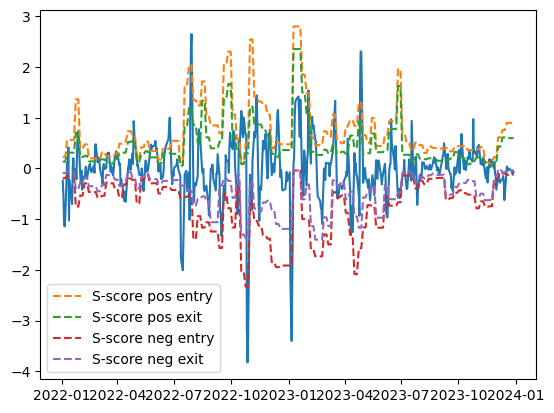

In [223]:
plt.plot(df_signal['s_score'])
plt.plot(df_signal['S_pos_entry'], label='S-score pos entry', ls='--')
plt.plot(df_signal['S_pos_exit'], label='S-score pos exit', ls='--')
plt.plot(df_signal['S_neg_entry'], label='S-score neg entry', ls='--')
plt.plot(df_signal['S_neg_exit'], label='S-score neg exit', ls='--')
plt.legend()
plt.show()